# Background
After I reviewed AutoGluon, I wanna benchmark other model. And I read article so i summarized it.

Test the potentials of AutoGluon and compare its performance with other popular ML methods. __benchmark will be classic random forest, as well as XGBoost (extreme gradient boosting), which has also been a prevailing technique for supervised learning.__ It features optimal computing resource allocation, which contributes to its fast execution speed and extremely high accuracy. 

XGBoost has been considered as the go-to algorithm for winners in Kaggle data competitions.
The main task to compare model performance will be loan default prediction, which involves predicting whether a person with given features would default on a bank loan.

In [165]:
import itertools
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split   
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import autogluon as ag
from autogluon import TabularPrediction as task

from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap,origin='lower')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i+0.1, cm[i, j],
                               color= "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Preparation
 dataset was obtained from the Kaggle website. It consists of 30,000 observations of individuals currently in debt and their basic information, including id, sex, education, marriage, age, and given credit. The dataset also contains repayments status, amount of bill statement, and amount of previous payment in consecutive 6 months, as well as the default indicator during the next month. The original dataset was already very clean. We dummy coded the categorical variables (which is required for running XGBoost), i.e., converted categorical variables into a series of dichotomous variables with only levels of 0 and 1.

In [167]:
df = pd.read_csv("/data1/kaggle/default_of_creditcard/creditcard.csv",index_col="ID")
categorical_columns =['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
df=pd.get_dummies(df, columns=categorical_columns)

In [168]:
df.columns
df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,...,1,0,0,0,0,0,0,0,0,0
2,120000.0,26,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,...,0,0,0,1,0,0,0,0,0,0
3,90000.0,34,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,...,0,0,1,0,0,0,0,0,0,0
4,50000.0,37,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,...,0,0,1,0,0,0,0,0,0,0
5,50000.0,57,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,...,0,0,1,0,0,0,0,0,0,0


In [169]:
columns = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

train, test = train_test_split(df,
                               test_size=0.2,
                               random_state=42,
                               shuffle=True)

train_data = pd.DataFrame(scale(train.loc[:, columns]))
test_data = pd.DataFrame(scale(test.loc[:, columns]))

train_data.columns = columns
test_data.columns = columns

label_column='default.payment.next.month'
train_data[label_column] = train[label_column]
test_data[label_column] = test[label_column]

train_data = train_data.dropna(axis = 0, how = 'any')
test_data = test_data.dropna(axis = 0, how = 'any')

X_train = train_data[columns]
y_train = train_data[label_column]
X_test = test_data[columns]
y_test = test_data[label_column]

X=df.drop(['default.payment.next.month'],axis=1)
y=df.loc[:,['default.payment.next.month']]

# Implement

## Autogluon
Amazon claims that AutoGluon performs exceptionally well in various data tasks that involve image, text, and tabular data. In our study, we focused on predicting with tabular data. Unlike random forest and XGBoost, __AutoGluon takes care of model selection and hyperparameter tuning.__ The first step it takes is to use ML to determine several models that would be appropriate for the given task. After the models are determined, AutoGluon utilizes ML again to optimize the hyperparameters of each model. For example, if AutoGluon “thinks” random forest is a good model for the task, it will then decide the number of decision trees in the forest, as well as the number of features considered when splitting a node.

In [170]:
#Auto-GLuon without setting parameters
print("Summary of class variable: \n", train_data[label_column].describe())
dir = 'agModels-predictClass' # specifies folder where to store trained models

predictor = task.fit(train_data=train_data, 
                     label=label_column, 
                     output_directory=dir)

Beginning AutoGluon training ...
Preprocessing data ...
Here are the first 10 unique label values in your data:  [1. 0.]
AutoGluon infers your prediction problem is: binary  (because only two unique label-values observed)
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Selected class <--> label mapping:  class 1 = True, class 0 = False
	Data preprocessing and feature engineering runtime = 0.05s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
Fitting model: RandomForestClassifierGini ...


Summary of class variable: 
 count    19190.000000
mean         0.224544
std          0.417293
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default.payment.next.month, dtype: float64


	1.29s	 = Training runtime
	0.7639	 = Validation accuracy score
Fitting model: RandomForestClassifierEntr ...
	2.03s	 = Training runtime
	0.766	 = Validation accuracy score
Fitting model: ExtraTreesClassifierGini ...
	0.8s	 = Training runtime
	0.7629	 = Validation accuracy score
Fitting model: ExtraTreesClassifierEntr ...
	0.9s	 = Training runtime
	0.766	 = Validation accuracy score
Fitting model: KNeighborsClassifierUnif ...
	0.03s	 = Training runtime
	0.7332	 = Validation accuracy score
Fitting model: KNeighborsClassifierDist ...
	0.03s	 = Training runtime
	0.7243	 = Validation accuracy score
Fitting model: LightGBMClassifier ...
	4.23s	 = Training runtime
	0.7754	 = Validation accuracy score
Fitting model: CatboostClassifier ...
	1.99s	 = Training runtime
	0.7754	 = Validation accuracy score
Fitting model: NeuralNetClassifier ...
	21.61s	 = Training runtime
	0.7754	 = Validation accuracy score
Fitting model: LightGBMClassifierCustom ...
	16.14s	 = Training runtime
	0.7759	 = Validat

Beginning AutoGluon training ...
Preprocessing data ...
Here are the first 10 unique label values in your data:  [1. 0.]
AutoGluon infers your prediction problem is: binary  (because only two unique label-values observed)
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Selected class <--> label mapping:  class 1 = True, class 0 = False
	Data preprocessing and feature engineering runtime = 0.06s ...
AutoGluon will gauge predictive performance using evaluation metric: accuracy
To change this, specify the eval_metric argument of fit()
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 5


Finished Task with config: {'feature_fraction': 1.0, 'learning_rate': 0.1, 'min_data_in_leaf': 20, 'num_leaves': 36} and reward: 0.7754038561750912
Finished Task with config: {'feature_fraction': 0.8506280596831612, 'learning_rate': 0.02488607164658111, 'min_data_in_leaf': 6, 'num_leaves': 33} and reward: 0.7754038561750912
Finished Task with config: {'feature_fraction': 0.831425584183886, 'learning_rate': 0.08700388920415902, 'min_data_in_leaf': 8, 'num_leaves': 30} and reward: 0.7756644085461177
Finished Task with config: {'feature_fraction': 0.7538877429776024, 'learning_rate': 0.07171868391017054, 'min_data_in_leaf': 29, 'num_leaves': 49} and reward: 0.7754038561750912


Finished Task with config: {'feature_fraction': 0.7542087194968854, 'learning_rate': 0.08717983218304236, 'min_data_in_leaf': 26, 'num_leaves': 64} and reward: 0.7756644085461177
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 5


Finished Task with config: {'activation.choice': 0, 'dropout_prob': 0.1, 'embedding_size_factor': 1.0, 'layers.choice': 0, 'learning_rate': 0.0005, 'network_type.choice': 0, 'use_batchnorm.choice': 0, 'weight_decay': 1e-06} and reward: 0.7754038561750912
Finished Task with config: {'activation.choice': 0, 'dropout_prob': 0.05570033822312098, 'embedding_size_factor': 1.295249453916624, 'layers.choice': 2, 'learning_rate': 0.00018727831133111538, 'network_type.choice': 0, 'use_batchnorm.choice': 1, 'weight_decay': 8.021626928222015e-09} and reward: 0.7754038561750912
Finished Task with config: {'activation.choice': 0, 'dropout_prob': 0.3758880029187216, 'embedding_size_factor': 1.3067843640084864, 'layers.choice': 3, 'learning_rate': 0.00592751419459852, 'network_type.choice': 1, 'use_batchnorm.choice': 1, 'weight_decay': 5.094967656995661e-10} and reward: 0.7754038561750912
Finished Task with config: {'activation.choice': 0, 'dropout_prob': 0.4345566193292123, 'embedding_size_factor': 0

Finished Task with config: {'activation.choice': 2, 'dropout_prob': 0.402454749726802, 'embedding_size_factor': 1.095470639525927, 'layers.choice': 2, 'learning_rate': 0.002921042388266138, 'network_type.choice': 1, 'use_batchnorm.choice': 1, 'weight_decay': 0.0014619695187479632} and reward: 0.7754038561750912
Please either provide filename or allow plot in get_training_curves
Fitting model: weighted_ensemble_l1 ...
	1.17s	 = Training runtime
	0.7757	 = Validation accuracy score
AutoGluon training complete, total runtime = 57.92s ...


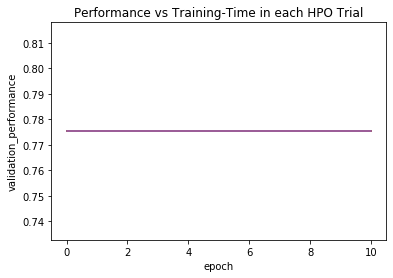

In [171]:
#Auto-GLuon with setting parameters
dir = 'agModels-predictClass' # specifies folder where to store trained models
hp_tune = True  # whether or not to do hyperparameter optimization

nn_options = { # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10, # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True), # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'), # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),
      # Each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1), # dropout probability (real-valued hyperparameter)
}

gbm_options = { # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100, # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36), # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {'NN': nn_options, 'GBM': gbm_options}  # hyperparameters of each model type
# If one of these keys is missing from hyperparameters dict, then no models of that type are trained.

num_trials = 5  # try at most 3 different hyperparameter configurations for each type of model
search_strategy = 'skopt'  # to tune hyperparameters using SKopt Bayesian optimization routine
predictor = task.fit(train_data=train_data, 
                     label=label_column, 
                     output_directory=dir, 
                     num_trials=num_trials,
                     hyperparameter_tune=True, 
                     hyperparameters=hyperparameters)

In [172]:
y_pred = predictor.predict(X_test)

Confusion matrix, without normalization
[[904   0]
 [275   0]]


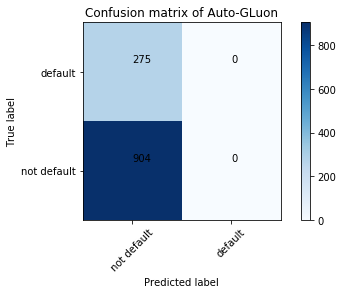

In [173]:
# Plot normalized confusion matrix
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['not default','default'], 
                      normalize=False,
                      title='Confusion matrix of Auto-GLuon')

plt.show()

In [174]:
roc_auc_score(y_test, y_pred)
print("Predictions:  ", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.766751
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
Evaluations on test data:
{
    "accuracy": 0.7667514843087362,
    "accuracy_score": 0.7667514843087362,
    "balanced_accuracy_score": 0.5,
    "matthews_corrcoef": 0.0,
    "f1_score": 0.7667514843087362
}
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Detailed (per-class) classification report:
{
    "0.0": {
        "precision": 0.7667514843087362,
        "recall": 1.0,
        "f1-score": 0.8679788766202592,
        "support": 904
    },
    "1.0": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-scor

Predictions:   [False False False ... False False False]


In [175]:
accuracy = float(np.sum(y_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.766751


In [176]:
y_pred_prob = predictor.predict_proba(X_test)

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Generate ROC curve values: 
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob )

AUC: 0.5106818181818182


*** Summary of fit() ***
Number of models trained: 11
Types of models trained: 
{'WeightedEnsembleModel', 'TabularNeuralNetModel', 'LGBModel'}
Validation performance of individual models: {'LightGBMClassifier_trial_50': 0.7754038561750912, 'LightGBMClassifier_trial_51': 0.7754038561750912, 'LightGBMClassifier_trial_52': 0.7756644085461177, 'LightGBMClassifier_trial_53': 0.7754038561750912, 'LightGBMClassifier_trial_54': 0.7756644085461177, 'NeuralNetClassifier_trial_55': 0.7754038561750912, 'NeuralNetClassifier_trial_56': 0.7754038561750912, 'NeuralNetClassifier_trial_57': 0.7754038561750912, 'NeuralNetClassifier_trial_58': 0.7754038561750912, 'NeuralNetClassifier_trial_59': 0.7754038561750912, 'weighted_ensemble_l1': 0.7756644085461177}
Best model (based on validation performance): weighted_ensemble_l1
Hyperparameter-tuning used: True
Bagging used: False 
Stack-ensembling used: False 
User-specified hyperparameters:
{'NN': {'num_epochs': 10, 'learning_rate': Real: lower=0.0001, upper=

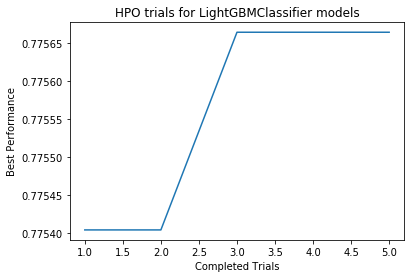

Plot summary of models saved to file: NeuralNetClassifier_HPOmodelsummary.html
Plot of HPO performance saved to file: agModels-predictClass/NeuralNetClassifier_HPOperformanceVStrials.png


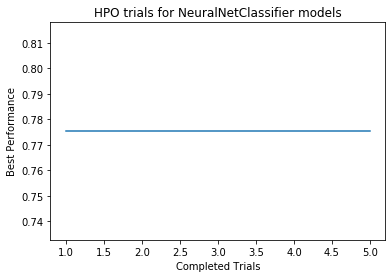

*** Details of Hyperparameter optimization ***
HPO for LightGBMClassifier model:  Num. configurations tried = 5, Time spent = 18.834564447402954, Search strategy = random
Best hyperparameter-configuration (validation-performance: accuracy = 0.7756644085461177):
{'feature_fraction': 0.831425584183886, 'learning_rate': 0.08700388920415902, 'min_data_in_leaf': 8, 'num_leaves': 30}
HPO for NeuralNetClassifier model:  Num. configurations tried = 5, Time spent = 34.5629096031189, Search strategy = random
Best hyperparameter-configuration (validation-performance: accuracy = 0.7754038561750912):
{'activation.choice': 0, 'dropout_prob': 0.1, 'embedding_size_factor': 1.0, 'layers.choice': 0, 'learning_rate': 0.0005, 'network_type.choice': 0, 'use_batchnorm.choice': 0, 'weight_decay': 1e-06}
*** End of fit() summary ***
AutoGluon infers problem type is:  binary
AutoGluon categorized the features as:  {'nlp': [], 'vectorizers': [], 'float': ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3

In [177]:
results = predictor.fit_summary()
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon categorized the features as: ", predictor.feature_types)

## XGBoost
XGBoost is a successor of random forest and is considered as the crown jewel of the decision-tree-based ensemble ML algorithms. It was originally developed at the University of Washington in 2016 by Tianqi Chen and Carlos Guestrin, and quickly gained enormous popularity in the data science industry. XGBoost improves upon Gradient Boosting Machines through systems optimization and algorithmic enhancements.

![title](assets/XGBoost.PNG)

the performance of XGBoost is significantly better than traditional algorithms in terms of accuracy and computing efficiency. the result is shown in the following graph:

![title](assets/XGBoost_Performance.PNG)

Since XGBoost has excellent performance when it comes to prediction problems with tabular data, we believe it can be a strong contender of AutoGluon in this case. We ran XGBoost to build the model for loan default prediction:

In [178]:
#XGBoostClassifier
model=xgb.XGBClassifier(
    base_score=0.5, booster='gbtree', colsample_bylevel=1,
    colsample_bynode=1, colsample_bytree=1, gamma=0,
    learning_rate=0.3, max_delta_step=0, max_depth=3,
    min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
    nthread=None, objective='binary:logistic', random_state=0,
    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
    silent=None, subsample=1, verbosity=1)

model.fit(X_train,y_train)
preds=model.predict(X_test)
print(preds)
acc = accuracy_score(y_test, preds)
print("Test set accuracy: {:.2f}".format(acc))

[0. 0. 0. ... 0. 0. 0.]
Test set accuracy: 0.77


/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/xgboost/sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[0. 0. 0. ... 0. 0. 0.]
Test set accuracy: 0.77
Confusion matrix, without normalization
[[904   0]
 [275   0]]


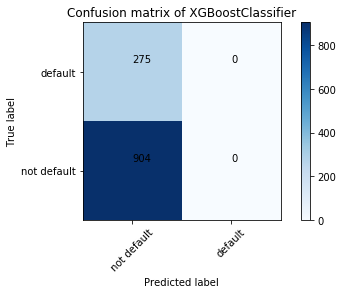

In [179]:
preds=model.predict(X_test)
print(preds)
acc = accuracy_score(y_test,preds)
print("Test set accuracy: {:.2f}".format(acc))

# Plot normalized confusion matrix
cnf_matrix=confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['not default','default'], 
                      normalize=False,
                      title='Confusion matrix of XGBoostClassifier')

plt.show()

[0.2471552  0.2261055  0.2471552  ... 0.22926143 0.2428923  0.23078021]


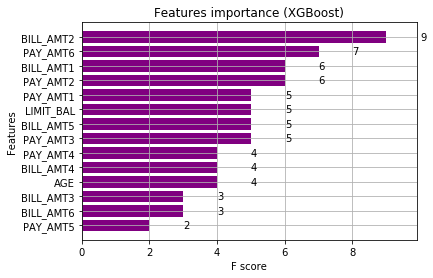

In [180]:
y_pred_prob = model.predict_proba(X_test)[:,1]
print(y_pred_prob)

# Generate ROC curve values: 
fpr2, tpr2, thresholds = roc_curve(y_test,y_pred_prob )
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)",  color="purple") 

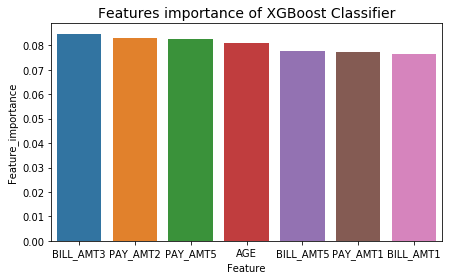

In [181]:
impo=model.feature_importances_

tmp = pd.DataFrame({'Feature': columns, 'Feature_importance': impo})
tmp = tmp.sort_values(by='Feature_importance',ascending=False)
tmp=tmp.iloc[:7,:]

plt.figure(figsize = (7,4))
plt.title('Features importance of XGBoost Classifier',fontsize=14)
s = sns.barplot('Feature','Feature_importance',data=tmp)

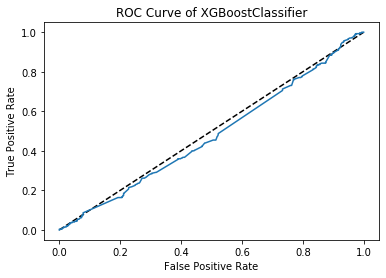

In [182]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of XGBoostClassifier')
plt.show()

In [183]:
y_pred_prob = model.predict_proba(X_test)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(model, X, y, cv=5,scoring="roc_auc")
print("AUC scores computed using 5-fold cross-validation: {}".format(np.mean(cv_auc)))

AUC: 0.4786866452131939


/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/xgboost/sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/xgboost/sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_sta

AUC scores computed using 5-fold cross-validation: 0.7712839706833826


## Logistic Regression With Tuned Hyperparameters

In [184]:
#Logistic Regression: Hyperparameter tuning with GridSearchCV
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {"C": c_space, "penalty": ['l1', 'l2']}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'penalty': 'l1'}
Best score is 0.8207333333333333


In [185]:
#{'C': 3.727593720314938, 'penalty': 'l1'}
logreg = LogisticRegression(penalty='l1',C=3.727593720314938)
# Fit the classifier to the training data
logreg.fit(X_train,y_train)
# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[904   0]
 [275   0]]
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       904
         1.0       0.00      0.00      0.00       275

    accuracy                           0.77      1179
   macro avg       0.38      0.50      0.43      1179
weighted avg       0.59      0.77      0.67      1179

Confusion matrix, without normalization
[[904   0]
 [275   0]]


/home/labs/anaconda3/envs/deploy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


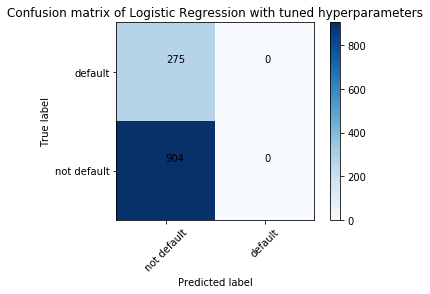

In [186]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['not default','default'], 
                      normalize=False,
                      title='Confusion matrix of Logistic Regression with tuned hyperparameters')

plt.show()

AUC: 0.47439662107803704


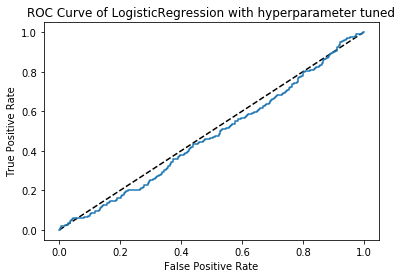

In [187]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
# Generate ROC curve values: 
fpr3, tpr3, thresholds = roc_curve(y_test,y_pred_prob )

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr3, tpr3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of LogisticRegression with hyperparameter tuned')
plt.show()

In [188]:
#Decision Tree(CART model)
#Hyperparameter tuning with RandomizedSearchCV
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train,y_train)
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3}
Best score is 0.7754559666492965


## DecisionTree

In [189]:
#Best CART model:
param_dist = {"max_depth": [3],
              "max_features": 4,
              "min_samples_leaf": 5,
              "criterion": ['entropy']}

tree = DecisionTreeClassifier(max_depth=3,
                              criterion='entropy',
                              max_features=4,
                              min_samples_leaf=5)

tree_cv.fit(X_train, y_train)
y_pred = tree_cv.predict(X_test)

[[903   1]
 [275   0]]
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       904
         1.0       0.00      0.00      0.00       275

    accuracy                           0.77      1179
   macro avg       0.38      0.50      0.43      1179
weighted avg       0.59      0.77      0.67      1179

Confusion matrix, without normalization
[[903   1]
 [275   0]]


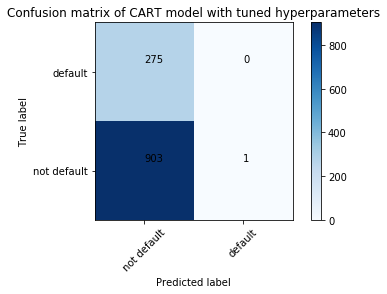

In [190]:
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['not default','default'], 
                      normalize=False,
                      title='Confusion matrix of CART model with tuned hyperparameters')

plt.show()

AUC: 0.47439662107803704


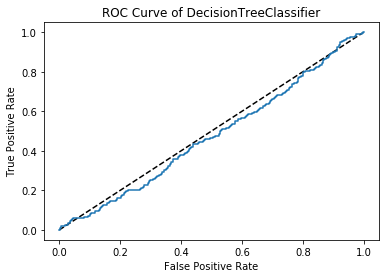

In [191]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
# Generate ROC curve values: 
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob )

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr4, tpr4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of DecisionTreeClassifier')
plt.show()

## RandomForest
It is an ensemble learning method for classification. The model randomly samples training data and creates subsets of features in order to build hundreds or thousands of decision trees, then aggregate all the trees together. Random forest has been one of the most popular ML methods because of its high accuracy.


In [192]:
#RandomForestClassifier
rm = RandomForestClassifier(
                             random_state=123,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)

rm.fit(X_train,y_train)
y_pred=rm.predict(X_test)

rm.feature_importances_

array([0.07108957, 0.0839607 , 0.08736936, 0.07801532, 0.07499261,
       0.07425987, 0.07345878, 0.0728043 , 0.06771238, 0.06663351,
       0.06289949, 0.06149812, 0.06174284, 0.06356314])

In [193]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = rm.predict_proba(X_test)[:,1]
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
roc_auc_score(y_test,y_pred)

AUC: 0.4679002413515688


0.49944690265486724

accuracy: 0.765903
[[903   1]
 [275   0]]
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       904
         1.0       0.00      0.00      0.00       275

    accuracy                           0.77      1179
   macro avg       0.38      0.50      0.43      1179
weighted avg       0.59      0.77      0.67      1179

Confusion matrix, without normalization
[[903   1]
 [275   0]]


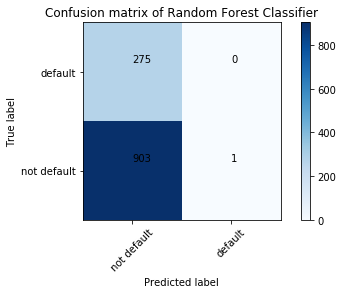

In [194]:
accuracy = accuracy_score(y_test,y_pred)
print("accuracy: %f" % (accuracy))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['not default','default'], normalize=False,
                      title='Confusion matrix of Random Forest Classifier')

plt.show()

AUC: 0.4679002413515688


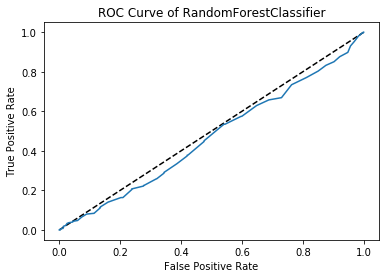

In [195]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
fpr5, tpr5, thresholds = roc_curve(y_test,y_pred_prob )

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr5, tpr5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of RandomForestClassifier')
plt.show()

# Conclusion
AutoGluon has the best model accuracy in terms of both the AUC score and the accuracy score. Besides, we found that AutoGluon was extremely easy to build, as it only took a few lines of code to complete and did not require any hyperparameter tuning.

doubt that it can fully replace data scientists for five major reasons:

- In unsupervised learning, there is no clear measure to assess the quality of results. Unsupervised learning is considered to be successful as long as it provides information that can be used in further analysis. Besides, the process requires significant domain knowledge. AutoML cannot provide sufficient help in this step.
- AutoML cannot deal with complex data such as network data and web data very well.
- Very few AutoML can handle feature engineering.
- AutoML cannot fully automate the process of conceiving business insights and implementing decision making.

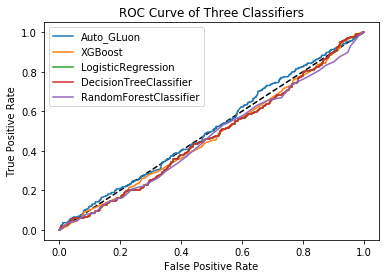

In [196]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr1, tpr1,label="Auto_GLuon")
plt.plot(fpr2, tpr2,label="XGBoost")
plt.plot(fpr3, tpr3,label="LogisticRegression")
plt.plot(fpr4, tpr4,label="DecisionTreeClassifier")
plt.plot(fpr5, tpr5,label="RandomForestClassifier")

plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Three Classifiers')
plt.show()